In [137]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [117]:
data = pd.read_csv('/kaggle/input/emotion-dataset/Emotion_classify_Data.csv')

In [118]:
data

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear
...,...,...
5932,i begun to feel distressed for you,fear
5933,i left feeling annoyed and angry thinking that...,anger
5934,i were to ever get married i d have everything...,joy
5935,i feel reluctant in applying there because i w...,fear


In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [120]:
stop_words = stopwords.words('english')
def process_text(text):
    text = re.sub(r'\d+',' ',text)
    text = text.split()
    text = " ".join([word for word in text if word.lower().strip() not in stop_words])
    return text
text = data['Comment'].apply(process_text)

In [121]:
tokenizer = Tokenizer(num_words=9000)
tokenizer.fit_on_texts(text)
text = tokenizer.texts_to_sequences(text)
max_length = np.max(list(map(lambda x : len(x),text)))

In [122]:
text = pad_sequences(text,maxlen=max_length,padding='post')

In [123]:
data['Emotion'] = data['Emotion'].apply(lambda x: 1 if x == 'joy' else 0)
x = text
y = data['Emotion']

In [124]:
y

0       0
1       0
2       0
3       1
4       0
       ..
5932    0
5933    0
5934    1
5935    0
5936    0
Name: Emotion, Length: 5937, dtype: int64

In [125]:
x_train , x_test , y_train , y_test = train_test_split(x,y,train_size=0.743,random_state=13)

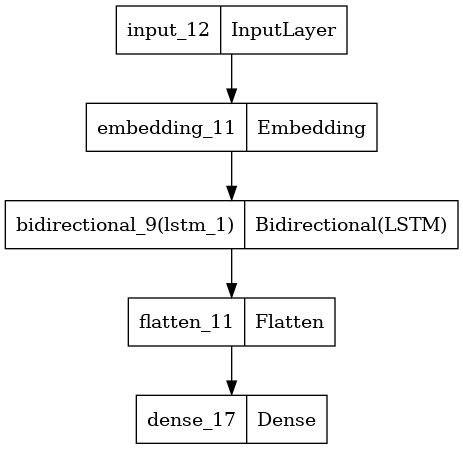

In [126]:
inputs = tf.keras.Input(shape=(max_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=9000
    ,output_dim=64
    ,input_length=max_length
)(inputs)

gru = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True))(embedding)

x = tf.keras.layers.Flatten()(gru)

output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs,outputs=output)

tf.keras.utils.plot_model(model)

In [127]:
model.compile(
    optimizer='adam'
    ,loss='binary_crossentropy'
    ,metrics=['accuracy',tf.keras.metrics.AUC(name='auc')]
)

In [128]:
hist = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy'
        ,patience=3
        ,restore_best_weights=True
    )
)

Epoch 1/100
111/111 [==============================] - 11s 46ms/step - loss: 0.5631 - accuracy: 0.7149 - auc: 0.6900 - val_loss: 0.2142 - val_accuracy: 0.9354 - val_auc: 0.9763
Epoch 2/100
111/111 [==============================] - 4s 36ms/step - loss: 0.0797 - accuracy: 0.9700 - auc: 0.9954 - val_loss: 0.1608 - val_accuracy: 0.9343 - val_auc: 0.9849
Epoch 3/100
111/111 [==============================] - 4s 36ms/step - loss: 0.0043 - accuracy: 0.9986 - auc: 1.0000 - val_loss: 0.2731 - val_accuracy: 0.9264 - val_auc: 0.9680
Epoch 4/100
111/111 [==============================] - 4s 36ms/step - loss: 0.0123 - accuracy: 0.9960 - auc: 0.9995 - val_loss: 0.2223 - val_accuracy: 0.9309 - val_auc: 0.9740


In [129]:
model.evaluate(x_test,y_test)

48/48 [==============================] - 1s 11ms/step - loss: 0.2626 - accuracy: 0.8925 - auc: 0.9559


[0.26263192296028137, 0.8925294876098633, 0.9559392929077148]

In [135]:
pred = np.squeeze(model.predict(x_test) >= 0.5).astype(np.int)

48/48 [==============================] - 1s 9ms/step


/tmp/ipykernel_32/4031740795.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = np.squeeze(model.predict(x_test) >= 0.5).astype(np.int)


In [138]:
f1_score(pred,y_test)

0.8190899001109878

484